# Multinomial logistic decoders


SKlearn fit

Continuous data, time series


Last week we ended with a PyTorch implementation of a multifeature logistic classifier. We were able to have it determine whether a thumb movement had been initiated based on the profile of spectral changes across multiple ECoG electrodes lying over motor cortex. Detecting whether a single movement has occurred is a binary output, True or False. This is limited. Ideally our decoder would be able to read-out a variety of movements. This problem is known as *multinomial* or *multiclass classification*. For that, a set of features is given, just like before, and the probability of those features being associated with each of $K$ possibilities is returned. 

This week we will explore how to extend our logistic decoder in Pytorch to achieve this. This will help us better understand the principles behind multiclass classification. Then, we will use the LogisticRegression class in Scikit Learn, which has multiclass classification built-in.

In [1]:
import os.path as op
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from IPython.display import HTML
import torch
from torch.utils.data import Dataset, DataLoader
from source.utils import zscore
from source.loaders import EcogFingerData
from source.decoders import LogRegPT, format_ecogfinger_data

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

## Activity profiles for different finger movements

In the ECoG dataset we are working with, subjects were prompted to move each finger separately. Throughout the session, the ECoG was recorded from a grid of electrodes centered on the motor cortex. We detected the finger movements from sensors attached to the fingers and examined the corresponding spectral changes in brain activity on each electrode. On average, each finger movement was associated with a distinctive spectral profile across frequencies and channels.

![spectral profiles](./images/SpectralProfiles.png)

We then trained a multifeature logisitic decoder to use the pattern of spectral changes across electrodes to determine if a thumb movement was initiated or not. Half the trials given to it were the spectral changes associated with thumb movements, while the other half were periods approximately 1 second before a thumb movement, during which presumably no finger movements occured. Not so surprisingly, the weights used in the decoder had a similar appearance to the spectral profile associated with the thumb movement, especially with L2 regularization.

![fitting coefficients](./images/FittingCoefficients.png)

This decoder only has one output whose value bounded between 0 and 1, so it can only provide a probability of a single event occurring or not. If we want to decode multiple fingers, that requires a model with multiple outputs, one for each finger. This can be envisioned as multiple outputs. If we know that only one finger (or no fingers) are moving at a time, then the problem is a *multiclass* classification problem where there are 6 outputs, one for each finger plus the no finger conditioning, and for every sample only one of the outputs should have a value of 1, indicating that its corresponding finger was moved. This is the type of classifier we will end on.

Alternatively, we could just keep five outputs, one for each finger, and encode the absence of a finger movement as being when all outputs deliver a probability less than 0.5. This is known as a *multilabel* classifier, where for each sample we are attempting to predict the set of events that occurred. This approach would also be used if subjects had been allowed to move multiple fingers at once, requiring multiple outputs to register a finger movement.

Both of these are examples of multinomial decoders. We can use these to decode multiple types of finger movements. To learn how to build such decoders, we will start with our original logistic decoder that we made in PyTorch and successively add features to it so that it behaves as a conventional multiclass decoder. The intermediate steps we take to this final outcome will each have problems. But, by implementing them, seeing how they fail, and fixing those failures, we will uncover how to properly construct a multinomial logistic decoder.  

## Multinomial decoding, the wrong way
Let's start by loading in our data and importing our PyTorch based logistic decoder. We will use the PyTorch version because it allows us to directly implement changes required in making a multinomial logistic decoder. 

In [2]:
# select dataset
subj = 'cc'
ecog_path = ['..', 'data/ecog/', subj, '{}_fingerflex.mat'.format(subj)]
ecog_file = op.join(*ecog_path)

# load data
ecog_data = EcogFingerData(ecog_file)

# list of finger names
finger_names = ['thumb', 'index', 'middle', 'ring', 'little']

Much the same as the previous week, except now we will load in spectrally processed ECoG samples from each finger movement. These will be pooled together into a dictionary to start.

In [3]:
feats = {}
lbls = {}
for ind, finger in enumerate(finger_names):
    feats[finger], lbls[finger] = format_ecogfinger_data(ecog_data, finger)

### Building a naive decoder
To build a simple multiclass decoder, we can try to pool together the results from decoders that were independently trained on each finger. Each is trained to detect whether a certain finger did or did not move, so if all of them return a probability of finger movement less than 0.5 we will declare that no finger was moved. Otherwise, the detected finger will be assigned to the decoder the returns the highest probability for finger movement that is greater than 0.5.

To start, we will a seperate logistic decoder on each finger. We will use mostly standard settings, except for setting the L1 penalty to a value that encourages a sparse weight matrix. As covered last week, this tended to improve the performance of the decoder on the held out test data set by discouraging memorization of the training examples.

In [4]:
# train a separate logistic regression model for each finger
lr_sgl = {}
print('Training individual models for each finger...')
print('Finger    Train     Test')
print('-------------------------')
for finger in finger_names:

    # initialize model
    lr_sgl[finger] = LogRegPT(lam=0.005) # use all data for training

    # fit model
    score_test, score_train = lr_sgl[finger].fit(feats[finger], lbls[finger])

    # print scores
    print('{:<10s}{:<10.0f}{:<10.0f}'.format(finger, score_train, score_test))


Training individual models for each finger...
Finger    Train     Test
-------------------------
thumb     100       86        
index     100       93        
middle    100       92        
ring      100       100       
little    100       92        


Fantastic performance on the training dataset, which isn't surprising. Performance on test sets was good as well. Not as good as the training, but that is to be expected. All decoders were able to classify correctly greater than 85% of the time between a movement or no movement of a given finger. 

Let's now attempt to pool our decoders together to determine if a finger was moved, and if so which one. For this we will run each docoder on data from all fingers. We will construct an array of prediction probabilities, where each row is a different event (lift of a finger, or no finger movement), and each column is the probability returned for a different finger decoder. If for a given event all decoders return a probability less than 0.5, we will treat that as a no finger movement event. Otherise, we will assign the finger whose model returned the highest probability.

Before we do that, though, we need to pool our data together and get just those trials that were used for testing.

In [5]:
# pool together all data
feats_all = np.concatenate([feats[finger] for finger in finger_names], axis=0)
lbls_all = np.concatenate([lbls[finger]*(i+1) for i,finger in enumerate(finger_names)], axis=0)

# extract those samples used for testing
idx_offset = 0
idx_test = []
for finger in finger_names:
    idx_test.append(idx_offset + lr_sgl[finger].test_idxs) # add offset to get global index
    idx_offset += len(lbls[finger]) # update offset
idx_test = np.concatenate(idx_test, axis=0)

# extract those samples used for training
feats_test = feats_all[idx_test]
lbls_test = lbls_all[idx_test]

In [9]:
def lr_nv(feats):
    '''
    Predict finger flexion using naive multinomial logistic regression.
    Pools the out of multiple single logistic regression models.
    '''

    # get probability predictions for each finger decoder
    pred_prob = np.zeros((feats.shape[0], len(finger_names)))
    for ind, finger in enumerate(finger_names):
        pred_prob[:,ind] = lr_sgl[finger].predict_proba(feats)

    # get predicted labels
    # get maximum probability across fingers
    pred_max = np.max(pred_prob, axis=1)

    # find the finger with the maximum probability
    pred_lbls = np.argmax(pred_prob, axis=1)+1

    # if maximum predictions has probability less than 0.5 set to 0 (no finger)
    pred_lbls[pred_max < 0.5] = 0

    return pred_lbls

# predict labels for test data
lbls_pred_nv = lr_nv(feats_test)

# get test score
score = balanced_accuracy_score(lbls_test, lbls_pred_nv)
print('Test score: {:.0f}%'.format(score*100))

Test score: 53%


A performance of 53% is much lower than single finge classification, but not awful, especially considering that with 6 classes the chance level is ~16%.

Now we want to visualize the performance of our predictions. For that, we will use a confusion matrix. Recall that we used these in Week 3 for evaluating the performance of our ERP detector. In that case, we had two possible outcomes, Cue or No-cue. Here, we have 6 different outcomes: No finger, thumb, index, middle, ring, and little. For each event we have a *true label* that we know is correct, and a *predicted label* that is what our model claims was the case. Each row of the confusion matrix corresponds to a different true label, and each column to a predicted label. The value in each cell is the probability of the model returning a predicted label given that the event had a particular true label. This means that a model performing perfectly will show values of 1 along the diagonal of its confusion matrix, indicating that the true label and predicted label always agreed. If cells off the diagonal have probabilities greater than zero, then it means the model was wrong in its prediction (i.e. confused). Representing this as a matrix makes the nature of the errors more clear. For instance, it may be that a particular type of event has more errors, which would appear as an entire row with elevated probabilities. Or that a model is prone to erroneously predicting one type of event over another, which would manifest as a column of higher probabilties.

The SciKit learn package offers functions for computing and displaying confusion matrices, so let's avail ourselves of them to see how our finger decoder performs.

Text(0.5, 1.0, 'Confusion Matrix for Naive Logistic Regression')

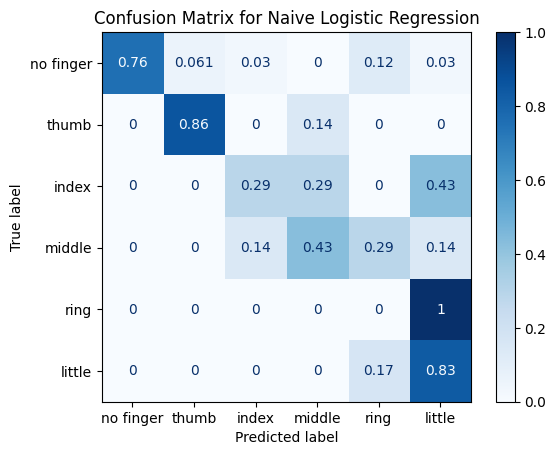

In [10]:
# calculate confusion matrix
cm_nv = confusion_matrix(lbls_test, lbls_pred_nv, normalize='true') # normalize by true labels

# plot confusion matrix
cmd = ConfusionMatrixDisplay(cm_nv, display_labels=['no finger']+finger_names)
im = cmd.plot(cmap='Blues')
im.im_.set_clim(0,1)
plt.title('Confusion Matrix for Naive Logistic Regression')

Notice that the total probability for each row is 1, meaning that the values represent the probability of a predicted label ($\hat{y}$) given the true label ($y$), expressed as $p(\hat{y}|y)$. The most salient feature of the confusion matrix is that the highest probabilties tend to lie along the diagonal. This means our decoder is performing better than chance, but not perfectly. There are off-diagonal elements with non-zero probabilities, indicating incorrect classifications. This is especially the case for the middle and ring fingers, who are misclassified more often than correctly predicted. 

Why might this be so? Individually, each decoder had greater than 90% accuracy for whether a given finger had moved or not on the test data. However, this is a different problem then what we are asking now, which is for a decoder to distinquish between different fingers. If the middle and ring finger evoke similar patterns of ECoG activity, then a decoder will have trouble distintiguishing them. This pattern is captured by the coefficients that our decoder uses. To see this, let's plot the coefficients used each decoder.

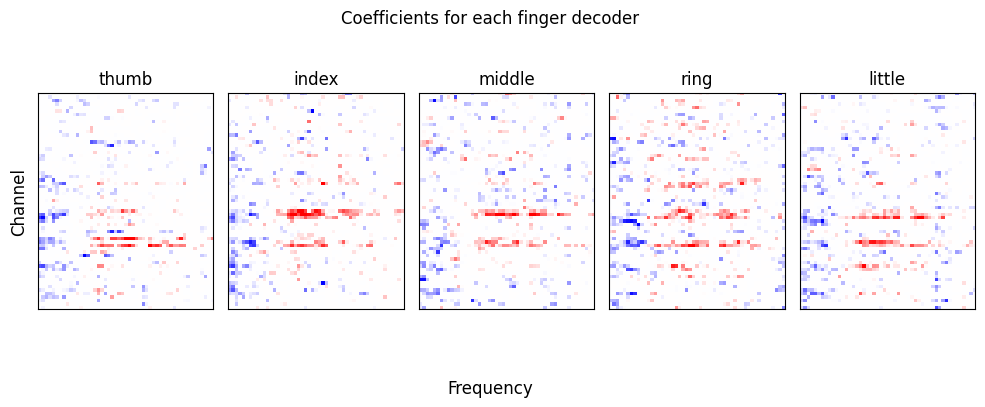

In [11]:
# Get the coefficients from each decoder
coefs_nv = np.zeros((len(finger_names), feats_all.shape[1]))

for ind, finger in enumerate(finger_names):
    coefs_nv[ind,:] = lr_sgl[finger].get_coefs()

# plot coefficients
fig, axs = plt.subplots(1, len(finger_names), figsize=(10,4))
for ind, finger in enumerate(finger_names):
    axs[ind].imshow(coefs_nv[ind,:].reshape((63,51)), cmap='bwr', norm=plt.Normalize(-0.1,0.1))
    axs[ind].set_title(finger)
    axs[ind].set_xticks([])
    axs[ind].set_yticks([])
    axs[ind].invert_yaxis()
fig.suptitle('Coefficients for each finger decoder')
fig.supxlabel('Frequency')
fig.supylabel('Channel')
fig.tight_layout()

We have extracted the coefficients from each decoder, reshaped them to reflect the channel by frequency organization of our features, and then plotted them for each finger. Red pixels have a positive weight, blue a negative, and white are at or near zero. The preponderance of zeros is because we used an L1 norm during the fitting. 

The coefficient map for the thumb is radically different than the others, while the ring and little look more similar to each other compared with the rest. Indeed, looking back at the confusion matrix we can see that movement of the ring finger had a 100% chance of being labeled as movement of the little finger. To more precisely capture the degree of similarities between the coefficients, we can measure their correlation with each other.

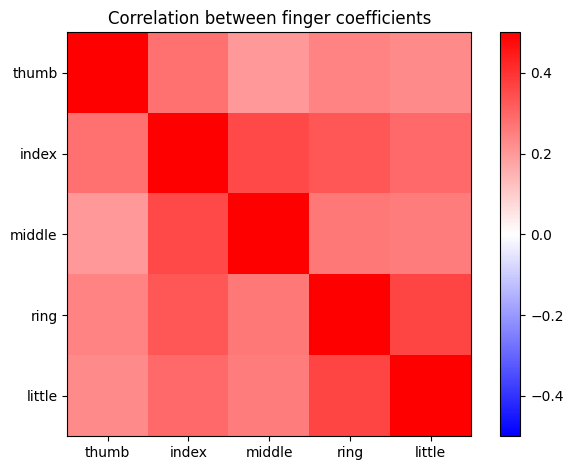

In [12]:
# plot correlation coefficients between each set of coefficients
corr = np.corrcoef(coefs_nv)
fig, ax = plt.subplots()
im = ax.imshow(corr, cmap='bwr', norm=plt.Normalize(-0.5,0.5))
fig.colorbar(im)
ax.set_xticks(np.arange(len(finger_names)))
ax.set_yticks(np.arange(len(finger_names)))
ax.set_xticklabels(finger_names)
ax.set_yticklabels(finger_names)
ax.set_title('Correlation between finger coefficients')
fig.tight_layout()


This confirms our impression that the coefficients used to detect each finger are generally similar to each other, since they all show positive correlations with each other. The coefficients used to detect thumb movement are most dissimilar to the others, and those for the ring and little finger are most alike. Because of this, the decoders will have trouble distinguishing between the movements of fingers, while still performing well when telling apart times when the finger was or was not moved. 

Think back to the formula we used for our multifeature logistic regression:
$$ \sigma(X)=\frac{1}{1-e^{-(b+WX)}} $$

Here $W$ is a vector of coeffients, and $X$ are the observed ECoG activity patterns. If the $W$ for the ring finger decoder is similar to the $W$ for the little finger decoder, than the two decoders will behave similarly and an ECoG pattern that would cause the detection of your little finger moving will also trigger a detection on the ring finger decoder. To visualize this, we can plot the distribution of $WX$ values for little and ring finger events, and compare those with no finger movement events. We will explore this using all the data, both training and testing, with the ring finger movement decoder coefficients.

We will also plot the decision line, where the logistic equation crosses 0.5 and an event is classified as ring finger movement. This will be when $WX=-b$, since $\frac{1}{1-e^0}=\frac{1}{1+1}=\frac{1}{2}$. 


In [18]:
(lbls_all.squeeze()).shape

(328,)

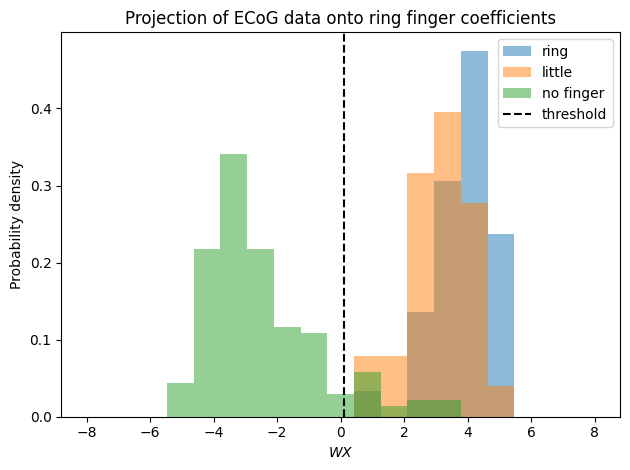

In [19]:
# get finger indices and model parameters for ring finger decoder
ring_ind = finger_names.index('ring')
little_ind = finger_names.index('little')
ring_coefs = coefs_nv[ring_ind,:]
ring_intercept = lr_sgl['ring'].get_intercept()

# calculate the projection of the data onto the ring finger coefficients
r_r_vals = feats_all[lbls_all.squeeze()==ring_ind+1,:].dot(ring_coefs)
l_r_vals = feats_all[lbls_all.squeeze()==little_ind+1,:].dot(ring_coefs)
n_r_vals = feats_all[lbls_all.squeeze()==0,:].dot(ring_coefs)

# plot the projection of the data onto the ring finger coefficients
fig, ax = plt.subplots()
bins = np.linspace(-8,8,20)
ax.hist(r_r_vals, bins=bins, alpha=0.5, label='ring', density=True)
ax.hist(l_r_vals, bins=bins, alpha=0.5, label='little', density=True)
ax.hist(n_r_vals, bins=bins, alpha=0.5, label='no finger', density=True)
ax.axvline(-ring_intercept, color='k', linestyle='--', label='threshold')
ax.set_xlabel('$WX$')
ax.set_ylabel('Probability density')
ax.set_title('Projection of ECoG data onto ring finger coefficients')
ax.legend()
fig.tight_layout()

The ring finger movement decoder is good at detecting when the ring finger has moved, compared to when it has not. Most of the no finger events are below the threshold, while all the ring finger movement events are above threshold. However, the same is also true for the little finger movement events. This means our ring finger movement detector can also act as a little finger movement detector. The question now is whether there is enough difference in the ECoG activity between ring and little finger movements for a decoder to tell the difference between them.

One way to answer that question is to try to visualize the distribution of ring vs little finger ECoG patterns. This is challenging because each event is composed of several thousand data points, making the data exceedingly high dimensional. A trick then is to try to reduce the dimensionality of the data, to take those several thousand data points and distill them down to just a few. If we get it down to two, those can then be plotted on a scatter plot. The literature on dimensionality reduction (also called embedding and manifold learning) is vast and beyond this lecture. Instead we will try to use the projection onto the decoder coefficients. This time, instead of just projecting the data onto the ring finger decoder, we will also project them onto the little finger decoder. We can then plot those projections as a scatter plot.

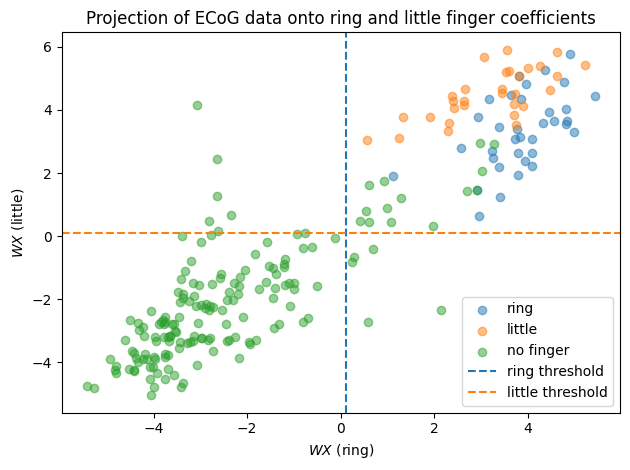

In [21]:
# get the projection of data onto the little finger coefficients
little_coefs = coefs_nv[little_ind,:]
little_intercept = lr_sgl['little'].get_intercept()
r_l_vals = feats_all[lbls_all.squeeze()==ring_ind+1,:].dot(little_coefs)
l_l_vals = feats_all[lbls_all.squeeze()==little_ind+1,:].dot(little_coefs)
n_l_vals = feats_all[lbls_all.squeeze()==0,:].dot(little_coefs)

# plot the projection of the data onto both sets of coefficients
fig, ax = plt.subplots()
ax.scatter(r_r_vals, r_l_vals, label='ring', alpha=0.5)
ax.scatter(l_r_vals, l_l_vals, label='little', alpha=0.5)
ax.scatter(n_r_vals, n_l_vals, label='no finger', alpha=0.5)
ax.axvline(-ring_intercept, color='tab:blue', linestyle='--', label='ring threshold')
ax.axhline(-little_intercept, color='tab:orange', linestyle='--', label='little threshold')
ax.set_xlabel('$WX$ (ring)')
ax.set_ylabel('$WX$ (little)')
ax.set_title('Projection of ECoG data onto ring and little finger coefficients')
ax.legend()
fig.tight_layout()

Most of the data points lie along a diagonal, indicating that coeffieficients of each model tend to transform the data similarly. As before, the greater segregration of events is between finger movement and no movement events, here shown as blue and orange data points exclusively above the thresholds, and green no movement data points mostly below the thresholds. Crucially, focusing on the ring and little finger event data points, we can see that they do not perfectly overlap. The ring finger movement data points tend to be offset from the little finger data points. That difference was not trained for, but this indicates that the ECoG patterns evoked by these events might be distinct enough to discriminate them. What we need to do now is train a decoder to do so.

What does this look like if we compare two fingers who were never confused? Let's create the same plot, but for thumb and ring finger.

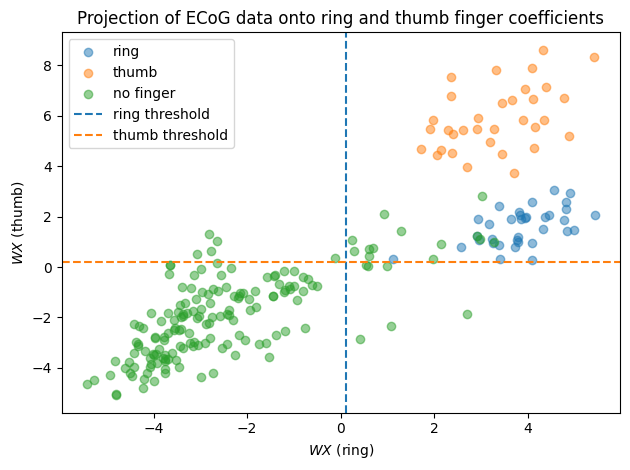

In [22]:
# get finger indices and model parameters for ring finger decoder
thumb_ind = finger_names.index('thumb')
little_ind = finger_names.index('little')
thumb_coefs = coefs_nv[thumb_ind,:]
thumb_intercept = lr_sgl['thumb'].get_intercept()

# calculate the projection of the data onto the thumb finger coefficients
r_t_vals = feats_all[lbls_all.squeeze()==ring_ind+1,:].dot(thumb_coefs)
t_t_vals = feats_all[lbls_all.squeeze()==thumb_ind+1,:].dot(thumb_coefs)
n_t_vals = feats_all[lbls_all.squeeze()==0,:].dot(thumb_coefs)

# calculate the projection of the thumb onto the ring finger coefficients
t_r_vals = feats_all[lbls_all.squeeze()==thumb_ind+1,:].dot(ring_coefs)

# plot the projection of the data onto both sets of coefficients
fig, ax = plt.subplots()
ax.scatter(r_r_vals, r_t_vals, label='ring', alpha=0.5)
ax.scatter(t_r_vals, t_t_vals, label='thumb', alpha=0.5)
ax.scatter(n_r_vals, n_t_vals, label='no finger', alpha=0.5)
ax.axvline(-ring_intercept, color='tab:blue', linestyle='--', label='ring threshold')
ax.axhline(-thumb_intercept, color='tab:orange', linestyle='--', label='thumb threshold')
ax.set_xlabel('$WX$ (ring)')
ax.set_ylabel('$WX$ (thumb)')
ax.set_title('Projection of ECoG data onto ring and thumb finger coefficients')
ax.legend()
fig.tight_layout()

The patterns associated with thumb and ring finger movements appear to be more separable. One could envision drawing a line between their two distributions of points such that all the thumb events lie on one side, and all the ring events on the other. This gives us hope that training a decoder to use this difference might improve our ability to detect individual finger movments.

### One versus rest multiclass decoder
If we wanted to construct a general decoder of finger movements, we could train a logistic decoder for each possible pair of finger movements: thumb vs. index, ring vs. little, etc. The number of possible pairs for $N$ classes of events is $N(N-1)/2$. In our case of five fingers, that would be $5(5-1)/2=20/2=10$. If we were to then run each of these ten decoders, we would predict that the finger who won out across the most of them is the finger that was moved. This is known as a *one versus one* (OvO) decoder. 

We will not use that strategy. Instead, we will experiment with a *one versus rest* approach (OvR, and sometimes referred to as 'one versus all'). In OvR, you train N decoders that each must discriminate between a specific event and all other events, e.g. thumb versus index or middle or ring or little. The decoder that returns the largest probability is the one that is associated with the finger moving. Conveniently, this only requires a simple change to our existing logistic decoder. 

To refresh our memory, originally our logistic decoder worked this way:
It received a sample as a vector
$$ 
samp  = 
\begin{bmatrix}
1 & f_{1,1} & f_{1,2} & \cdots & f_{ch,freq} \\
\end{bmatrix}
$$
with the 1 prepended for the intercept, and each feature the spectral power at a specific channel ($ch$) and frequency ($freq$).
The decoder had an intercept and weight parameters, like so:
$$
w  = 
\begin{bmatrix}
b \\
w_{1,1} \\
w_{1,2} \\ 
\vdots \\ 
w_{ch,freq} \\
\end{bmatrix}
$$

If we vertically concatenate each of the sample vectors, we can multiply them by $w$ and get a new vector where each element is proportional to the probability that a finger movement occured.
$$
\begin{bmatrix}
\text{---} & samp_{1} & \text{---} \\
\text{---} & samp_{2} & \text{---} \\
    & \vdots &   \\
\text{---} & samp_{N} & \text{---} \\
\end{bmatrix}
\begin{bmatrix}
b \\
w_{1,1} \\
w_{1,2} \\ 
\vdots \\ 
w_{ch,freq} \\
\end{bmatrix}
=
\begin{bmatrix}
z_1 \\
z_2 \\
\vdots \\
z_N \\
\end{bmatrix}
$$
Then, each result $z_i$ is passed through the sigmoid function
$$ \sigma(z_i) = \frac{1}{1-e^{-z_i}} $$
and if that was above 0.5 we decide that a finger movement had occured on $samp_i$.

To evaluate multiple decoders simultaneously, we turn our weight vector into a matrix, where each column is asociated with a logistic regression for a specific finger.
$$
\begin{bmatrix}
\color{yellow}\text{---} & \color{yellow}samp_{1} & \color{yellow}\text{---} \\
\text{---} & samp_{2} & \text{---} \\
    & \vdots &   \\
\text{---} & samp_{N} & \text{---} \\
\end{bmatrix}

\begin{bmatrix}
\color{blue}\vert & \vert & \vert & \vert & \vert \\
\color{blue}w_{t} & w_{i} & w_{m}& w_{r}& w_{l} \\
\color{blue}\vert & \vert & \vert & \vert & \vert \\
\end{bmatrix}
=
\begin{bmatrix}
\color{green}z_{1,t} & \color{yellow}z_{1,i} & \color{yellow}z_{1,m} & \color{yellow}z_{1,r} & \color{yellow}z_{1,l} \\
\color{blue}z_{2,t} & z_{2,i} & z_{2,m} & z_{2,r} & z_{2,l} \\
    &   &  \vdots &  & \\
\color{blue}z_{N,t} & z_{N,i} & z_{N,m} & z_{N,r} & z_{N,l} \\
\end{bmatrix}
$$

For clarity, sample one is highlighted in yellow, and the weights associated with the thumb decoder are in blue. When these two matrices are multiplied together, we get a new matrix of $z$ values, where samples are on the row axis and finger decoders are on the column axis. The green cell is the $z$ value for the thumb decoder on the first sample.

Put more concisely, $SW=Z$.
To determine which finger was raised, will apply the sigmoid transform to $Z$ for each row we identify the column (finger) with the largest probability. This can be expressed with the argmax function:

$$ 
pred_{i} = \underset{f=fingers}{\text{argmax}}\ \sigma(z_{i,f})
$$

The only major effect this will have on our training is that instead of our algorithm trying to fit a decoder between finger movement and no movement, it will instead optimize for the difference between moving a specific finger and all other fingers. During the fitting, the coefficients will update the same, since the loss will be propagated back through each column in matrix W independently. In addition, we will add an additional output (logistic decoder) for the no finger condition, which will have its own weights and intercept.

To implement this, we will modify our existing `LogRegPT` class. There are only a few spots we have to change. First, we need to change the Linear layer in our logistic regression model to now have 6 outputs, instead of the original one. Two, the `loss` method has to be modified to accept the 6 outputs instead of just one (more on this below). Lastly, the `predict` method needs to convert the 6 outputs of the network to labels by identifying which has the highest probability for each sample.


In [13]:
class LogRegPTOvR(LogRegPT):

    def _create_logreg(self, input_dim):
        # Parameters
        # ----------
        # input_dim : int
        #     Number of input features

        # linear layer is the weights and bias
        # input_dim is the number of input features and 6 is the number of output classes (5 fingers + no finger)
        # this is taking the matrix multiplication of the input features with the weights and adding the bias
        lin_layer = torch.nn.Linear(input_dim, 6) # <--- CHANGED HERE, 6 is the number of output classes

        # sigmoid layer is the activation function
        sig_layer = torch.nn.Sigmoid()

        # logistic regression model is a sequential combination of linear and sigmoid layers
        logreg = torch.nn.Sequential(
            lin_layer,
            sig_layer
        )
        self._logreg = logreg

    def loss(self, pred, lbl):
        # Parameters
        # ----------
        # pred : array-like
        #     Predicted probability of each sample being in class 1
        # lbl : array-like
        #     Array of labels, where each element is the label for the corresponding row in X

        # Returns
        # -------
        # loss : float
        #     Loss value

        loss_fn = torch.nn.BCELoss(reduction='mean')

        # convert integer labels to one-hot encoding
        # set tensor lbl to be an integer tensor
        lbl = lbl.type(torch.int64) # <--- CHANGED HERE, formatted to int to act as index tensor
        lbl = torch.nn.functional.one_hot(lbl, num_classes=6) # <--- CHANGED HERE, 6 is the number of output classes
        lbl = lbl.type(torch.float32)  # <--- CHANGED HERE, formatted to float for loss function

        # calculate loss
        loss = loss_fn(pred, lbl)
        loss += self.lam*torch.sum(torch.abs(self._logreg[0].weight)) # add L1 regularization

        return loss

    def predict(self, X):
        # Parameters
        # ----------
        # X : array-like
        #     Array of features, where each row is a trial and each column is a feature

        # Returns
        # -------
        # pred : array-like
        #     Predicted labels

        if self._logreg is None:
            raise ValueError('Logistic regression model has not been fit yet.')
        
        self._logreg.eval()

        X = torch.tensor(X.astype(np.float32))
        
        with torch.no_grad():
            pred = self._logreg(X)
            pred = pred.squeeze().numpy()
            pred_lbls = np.argmax(pred, axis=1) # <--- CHANGED HERE, convert to label

        return pred_lbls

Looking over this code, you will notice that the term 'one-hot' is used. This refers to a way to encode the classes. Originally when we trained single logistic decoders we encoded whether a finger moved or not as a binary variable, 0 or 1, at each sample. When we pooled the decoders together, we needed a way to label each finger uniquely (they can't all be 1). To do this, we did thumb = 1, index = 2, middle = 3, ring = 4, and little = 5. No finger movement was assigned to 0.

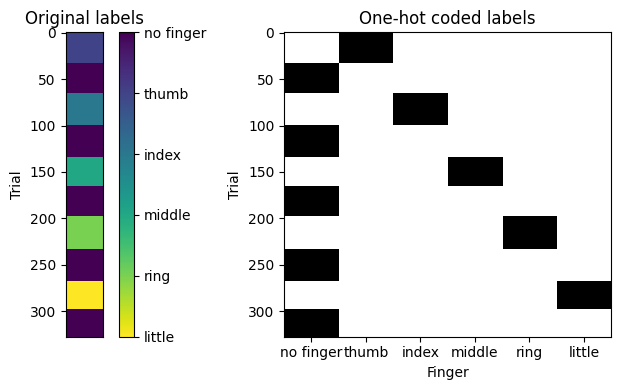

In [14]:
mult_lbls = ['no finger'] + finger_names

# create one-hot finger labels
flex_lbls_all_oh= np.zeros((flex_lbls_all.shape[0], len(mult_lbls)))
for ind, finger in enumerate(mult_lbls):
    flex_lbls_all_oh[flex_lbls_all==ind, ind] = 1


# plot the one-hot labels
fig, axs = plt.subplots(1,2, figsize=(8,4))
im = axs[0].imshow(flex_lbls_all[:,np.newaxis], aspect=0.025, interpolation='none')
axs[0].set_title('Original labels')
axs[0].set_ylabel('Trial')
axs[0].set_xticks([])
cbar = fig.colorbar(im, ax=axs[0], ticks=np.arange(len(mult_lbls)))
cbar.ax.set_yticklabels(mult_lbls)
cbar.ax.invert_yaxis()

axs[1].imshow(flex_lbls_all_oh, aspect='auto', cmap='gray_r', interpolation='none')
axs[1].set_title('One-hot coded labels')
axs[1].set_ylabel('Trial')
axs[1].set_xlabel('Finger')
axs[1].set_xticks(np.arange(len(mult_lbls)))
axs[1].set_xticklabels(mult_lbls)
fig.tight_layout()

In [15]:
# keep a random subset of no finger trials equal in number to the number of individual finger trials

# get the median number of labels for each finger
n_lbls = np.median(np.bincount(flex_lbls_all.astype(int))).astype(int)

# get the indices of the no finger trials
no_finger_inds = np.where(flex_lbls_all==0)[0]

# randomly select a subset of no finger trials to keep, equal in number to the median number of labels for each finger
no_finger_inds = np.random.choice(no_finger_inds, size=n_lbls, replace=False)

# keep the selected no finger trials and all of the individual finger trials
inds = np.concatenate([no_finger_inds, np.where(flex_lbls_all)[0]])
flex_feats_sub = flex_feats_all[inds,:]
flex_lbls_sub = flex_lbls_all[inds]

In [16]:
lr_ovr = LogRegPTOvR(train_prop=0.8, lam=0.005) # use all data for training
test_score, train_score = lr_ovr.fit(flex_feats_sub, flex_lbls_sub.astype(int))
print('Training score: {:.0f}%'.format(train_score))
print('Test score: {:.0f}%'.format(test_score))


Training score: 98%
Test score: 72%


Whoa, 66% is a far fall from 97%, but it is better than the 59% performance with our naive decoder.

To diagnose where things are going wrong, let's use the confusion matrix. We can compare it with the original confusion matrix from our naive decoder to see if the types of errors being made have changed.

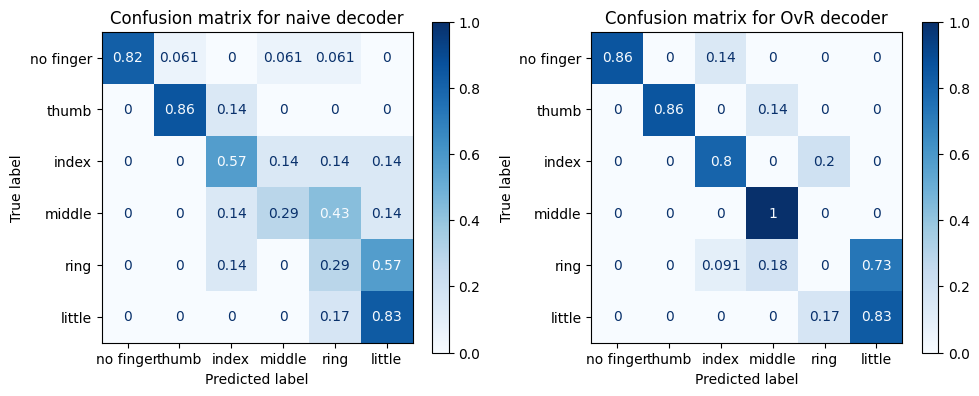

In [17]:
test_idxs = lr_ovr.test_idxs

# evaluate decoder performance using confusion matrix
flex_lbls_pred_test = lr_ovr.predict(flex_feats_sub[test_idxs,:])
flex_lbls_true_test = flex_lbls_sub[test_idxs]
cm_ovr = confusion_matrix(flex_lbls_true_test, flex_lbls_pred_test, normalize='true')

fig, ax = plt.subplots(1,2, figsize=(10,4))
cmd = ConfusionMatrixDisplay(cm_nv, display_labels=mult_lbls)
im = cmd.plot(cmap='Blues', ax=ax[0])
im.im_.set_clim(0,1)
im.ax_.set_title('Confusion matrix for naive decoder')

cmd = ConfusionMatrixDisplay(cm_ovr, display_labels=mult_lbls)
im = cmd.plot(cmap='Blues', ax=ax[1])
im.im_.set_clim(0,1)
im.ax_.set_title('Confusion matrix for OvR decoder')

fig.tight_layout()

Notice how the diagonal elements on the OvR confusion matrix tend to have higher probabilities now, this indicates that correct classifications have increased. In conjunction with that, more of the off-diagonal elements have been reduced to zero, which means we have fewer misclassifications. Performance for no finger and thumb have improved, which makes sense since the patterns of neural activity associated with them are the most different from the others. Index and middle fingers are still being confused, but less so, despite the similarities in their neural activity patterns. Correct classification for the ring finger is better, while little finger performance is dramatically worse. 

Given that the performance of each decoder depends on their weights, these should be different from the naive case.

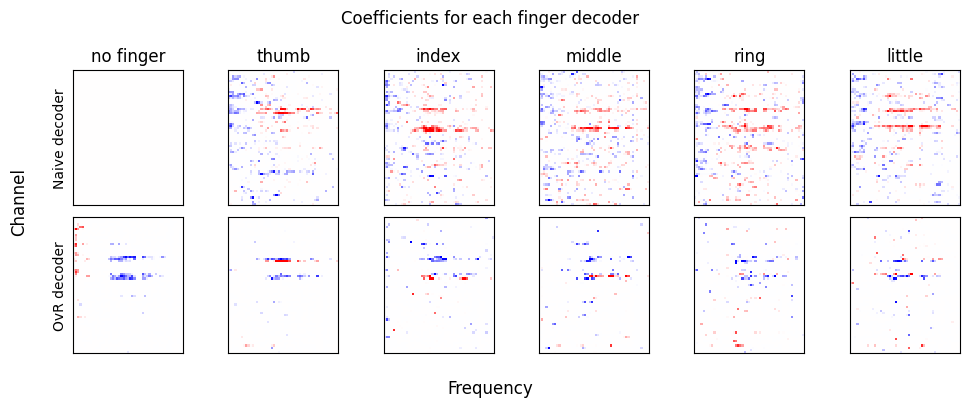

In [18]:
# Get the coefficients from each decoder
coefs_ovr = np.zeros((len(mult_lbls), flex_feats_sub.shape[1]))

coefs_ovr = lr_ovr.get_coefs()


# plot coefficients
fig, axs = plt.subplots(2, len(mult_lbls), figsize=(10,4))
for ind, finger in enumerate(mult_lbls):
    if finger == 'no finger':
        axs[0,ind].imshow(np.zeros((63,51)), cmap='bwr', norm=plt.Normalize(-0.1,0.1), interpolation='none')
        axs[0,ind].set_title(finger)
        axs[0,ind].set_xticks([])
        axs[0,ind].set_yticks([])
    else:
        axs[0,ind].imshow(coefs_nv[ind-1,:].reshape((63,51)), cmap='bwr', norm=plt.Normalize(-0.1,0.1), interpolation='none')
        axs[0,ind].set_title(finger)
        axs[0,ind].set_xticks([])
        axs[0,ind].set_yticks([])

    
    axs[1,ind].imshow(coefs_ovr[ind,:].reshape((63,51)), cmap='bwr', norm=plt.Normalize(-0.1,0.1), interpolation='none')
    axs[1,ind].set_xticks([])
    axs[1,ind].set_yticks([])

    if ind == 0:
        axs[0,ind].set_ylabel('Naive decoder')
        axs[1,ind].set_ylabel('OvR decoder')

fig.suptitle('Coefficients for each finger decoder')
fig.supxlabel('Frequency')
fig.supylabel('Channel')
fig.tight_layout()

For our naive decoder we only had 5 sets of weights, one for each finger. Now we have six with the no finger decoder added. Using the OvR strategy radically changed the weights our model learned. The naive decoder, where each finger was trained separately, had the strongest weights as positive values at gamma frequencies and localized to several channels that were common across all the fingers (except for the thumb). This is because each decoder is separating the no finger condition from the finger movement condition, and for many of the fingers the same channels are activated. 

The OvR decoder, on the other hand, is mostly composed of negative weights. The no finger decoder is composed of negative weights largely on the channels that were used by the naive decoder. This is so the logistic function will be decoding the **absence** of a finger movement. This can be imagined as a taking the average weights of the finger decoders from the naive, and then negating them to have the decoder give a high probability for samples where no finger movement was present. Dramatic changes were also present for the decoders of individual finger movements. The thumb, index, and middle fingers now have a mixture of positive and negative weights, each on a different subset of channels. These weights reflect the patterns of activities that are distinct between both the no finger and each of the other fingers. It is also apparent the the weights used for the ring and little fingers are not very distinct now, likely contributing to their increased degree of confusion by the decoder.

### But what about probability?

So far we have just chosen the decoder with the highest probability to indicate which finger (or no finger) was moved. For this task, at each moment in time, only one finger can be moving, so the probabilties returned by our model should add up to 1. Is this the case? Our decoder provides a `predict_proba` method similar to what is found in sklearn classifiers. This returns the probability assigned by the model for each finger. We can use this function to determine whether the probabilities are behaving correctly and adding up to 1 for each sample.

In [19]:
def print_prob_tbl(lr):

    idxs = lr.test_idxs
    # get probability predictions for each finger decoder
    pred_prob = lr.predict_proba(flex_feats_sub[idxs,:])

    # get the first 10 trials
    print_idxs = np.random.choice(pred_prob.shape[0], size=10, replace=False)
    pred_prob = pred_prob[print_idxs,:]

    # get the sum of the probabilities across fingers
    pred_prob_sum = np.sum(pred_prob, axis=1)

    # true label
    flex_lbls_tbl = flex_lbls_sub[idxs]
    flex_lbls_tbl = flex_lbls_tbl[print_idxs]

    # print the table header
    for lbl in mult_lbls:
        print('{:<10s}'.format(lbl), end='')
    print('{:<10s}'.format('Sum'))

    # print the table rows
    for ind in range(10):
        # color the true label green
        for ind2 in range(len(mult_lbls)):
            if ind2 == flex_lbls_tbl[ind]:
                print('\033[92m{:<10.2f}\033[0m'.format(pred_prob[ind,ind2]), end='')
            else:
                print('{:<10.2f}'.format(pred_prob[ind,ind2]), end='')
        print('{:<10.2f}'.format(pred_prob_sum[ind]))

print_prob_tbl(lr_ovr)

no finger thumb     index     middle    ring      little    Sum       
0.07      0.80      0.14      0.11      0.14      0.08      1.34      
0.05      0.11      0.10      0.11      0.31      0.44      1.12      
0.36      0.41      0.26      0.33      0.45      0.47      2.30      
0.22      0.11      0.30      0.55      0.52      0.36      2.06      
0.08      0.12      0.35      0.58      0.24      0.26      1.64      
0.06      0.14      0.44      0.40      0.38      0.14      1.56      
0.10      0.24      0.49      0.31      0.16      0.22      1.52      
0.08      0.89      0.21      0.11      0.11      0.12      1.52      
0.02      0.03      0.18      0.17      0.13      0.54      1.06      
0.03      0.09      0.60      0.38      0.17      0.16      1.42      


This table reveals that in general, the correct class (in green) has the highest probability, but the sum of the probabiltiies across all classes the sum of the probabilities exceeds 1. This makes our decoder effective at predicting which finger was moved, but not at assigning the probability to that prediction. 

What we need is a way to ensure that the sum of the outputs from the decoder equals 1. To do this, we will replace the sigmoid function with the *softmax function*. Just as the sigmoid function ensured that a single output would obey the properties of a probability, constraining values to be between 0 and 1, the softmax does the same for multiple outputs. It is:

$$ 
\sigma(Z)_i = \frac{e^{z_i}}{\sum_{j=1}^N{e^{z_j}}}
$$

The exponentiation ensures that the outputs of our linear layer are kept positive, which means we will never go below 0. Then, dividing by the sum of all the exponentiated class outputs, we force the total probability to be 1. To code the softmax function, you would:

In [20]:
def softmax(x):
    # Parameters
    # ----------
    # x : array-like
    #     Array of values

    # Returns
    # -------
    # x : array-like
    #     Array of values after softmax transformation

    return np.exp(x)/np.sum(np.exp(x))

Let's now get a feel for how it behaves by passing a few different types of inputs to it.

In [21]:
inp1 = np.array([1,2,3])
inp2 = np.array([1,2,3,4])
inp3 = np.array([1,2,3,4,5])

print('Softmax of [1,2,3]: {}'.format(softmax(inp1)))
print('Softmax of [1,2,3,4]: {}'.format(softmax(inp2)))
print('Softmax of [1,2,3,4,5]: {}'.format(softmax(inp3)))

Softmax of [1,2,3]: [0.09003057 0.24472847 0.66524096]
Softmax of [1,2,3,4]: [0.0320586  0.08714432 0.23688282 0.64391426]
Softmax of [1,2,3,4,5]: [0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]


The probability assigned to each input grows with its relative value. The smallest input has the smallest probability and the largest input has the largest probability. The probabilities also tend to shrink as the number of inputs increase. It is also the case that even though our inputs each have a difference of 1, their assigned probabilities grow exponentially the larger they are. Let's try some more inputs.

In [22]:
inp4 = inp1 - 2
inp5 = inp1 + 2

print('Softmax of [-1,0,1]: {}'.format(softmax(inp4)))
print('Softmax of [3,4,5]: {}'.format(softmax(inp5)))

Softmax of [-1,0,1]: [0.09003057 0.24472847 0.66524096]
Softmax of [3,4,5]: [0.09003057 0.24472847 0.66524096]


Here we can see that even when we give negative values, the probability returned is kept bounded between 0 and 1. In addition, shifting all our values by a constant amount does not change the returned probabilities. This is a simple consequence of how exponentials work:

$$
\begin{align}
\sigma(c+Z)_i &= \frac{e^{c+z_i}}{\sum_{j=1}^N{e^{c+z_j}}} \notag \\
             &= \frac{e^{c}e^{z_i}}{\sum_{j=1}^N{e^{c}e^{z_j}}} \notag \\
             &= \frac{e^{c}e^{z_i}}{e^{c}\sum_{j=1}^N{e^{z_j}}} \notag \\
             &= \frac{e^{z_i}\cancel{e^{c}}}{\cancel{e^{c}}\sum_{j=1}^N{e^{z_j}}} \notag \\
             &= \frac{e^{z_i}}{\sum_{j=1}^N{e^{z_j}}} \notag
\end{align}
$$

The softmax function is used at the output layer when performing multiclass decoding, and PyTorch includes it in the library. So we will now create a third version of our decoder, this time replacing the sigmoid layer with the softmax.

In [23]:
class LogRegPTSM(LogRegPTOvR):

    def _create_logreg(self, input_dim):
        # Parameters
        # ----------
        # input_dim : int
        #     Number of input features

        # linear layer is the weights and bias
        # input_dim is the number of input features and 6 is the number of output classes (5 fingers + no finger)
        # this is taking the matrix multiplication of the input features with the weights and adding the bias
        lin_layer = torch.nn.Linear(input_dim, 6) 
        
        # sigmoid layer is the activation function
        # sig_layer = torch.nn.Sigmoid() <--- CHANGED HERE, removed sigmoid layer, softmax is built into cross entropy loss

        # logistic regression model is a sequential combination of linear and sigmoid layers
        logreg = torch.nn.Sequential(
            lin_layer,
        #    sig_layer <--- CHANGED HERE, removed sigmoid layer, softmax is built into cross entropy loss
        )
        self._logreg = logreg

    def loss(self, pred, lbl):
        # Parameters
        # ----------
        # pred : array-like
        #     Predicted probability of each sample being in class 1
        # lbl : array-like
        #     Array of labels, where each element is the label for the corresponding row in X

        # Returns
        # -------
        # loss : float
        #     Loss value

        loss_fn = torch.nn.CrossEntropyLoss(reduction='mean') # <--- CHANGED HERE, cross entropy loss, has softmax built in

        # convert integer labels to one-hot encoding
        # set tensor lbl to be an integer tensor
        lbl = lbl.type(torch.int64)
        lbl = torch.nn.functional.one_hot(lbl, num_classes=6)
        lbl = lbl.type(torch.float32)

        # calculate loss
        loss = loss_fn(pred, lbl)
        loss += self.lam*torch.sum(torch.abs(self._logreg[0].weight)) # add L1 regularization

        return loss

    def predict_proba(self, X):
        # Parameters
        # ----------
        # X : array-like
        #     Array of features, where each row is a trial and each column is a feature

        # Returns
        # -------
        # pred : array-like
        #     Predicted probability of each sample being in class 1

        if self._logreg is None:
            raise ValueError('Logistic regression model has not been fit yet.')
        
        self._logreg.eval()

        X = torch.tensor(X.astype(np.float32))
        
        with torch.no_grad():
            pred = self._logreg(X)
            pred = torch.nn.functional.softmax(pred, dim=1) # <--- CHANGED HERE, softmax activation function added since it is not built into the model
            pred = pred.squeeze().numpy()

        return pred

In [24]:
lr_sm = LogRegPTSM(train_prop=0.8, lam=0.005) # use all data for training
test_score, train_score = lr_sm.fit(flex_feats_sub, flex_lbls_sub.astype(int))
print('Training score: {:.0f}%'.format(train_score))
print('Test score: {:.0f}%'.format(test_score))

Training score: 99%
Test score: 82%


In [25]:
print_prob_tbl(lr_sm)

no finger thumb     index     middle    ring      little    Sum       
0.32      0.05      0.24      0.12      0.05      0.22      1.00      
0.05      0.12      0.08      0.04      0.21      0.51      1.00      
0.00      0.00      0.00      1.00      0.00      0.00      1.00      
0.04      0.02      0.10      0.15      0.24      0.44      1.00      
0.00      0.00      0.00      0.99      0.00      0.00      1.00      
0.00      0.08      0.46      0.41      0.02      0.02      1.00      
0.01      0.02      0.11      0.08      0.41      0.38      1.00      
0.01      0.02      0.10      0.13      0.52      0.23      1.00      
0.07      0.03      0.07      0.45      0.25      0.13      1.00      
0.00      0.99      0.00      0.01      0.00      0.00      1.00      


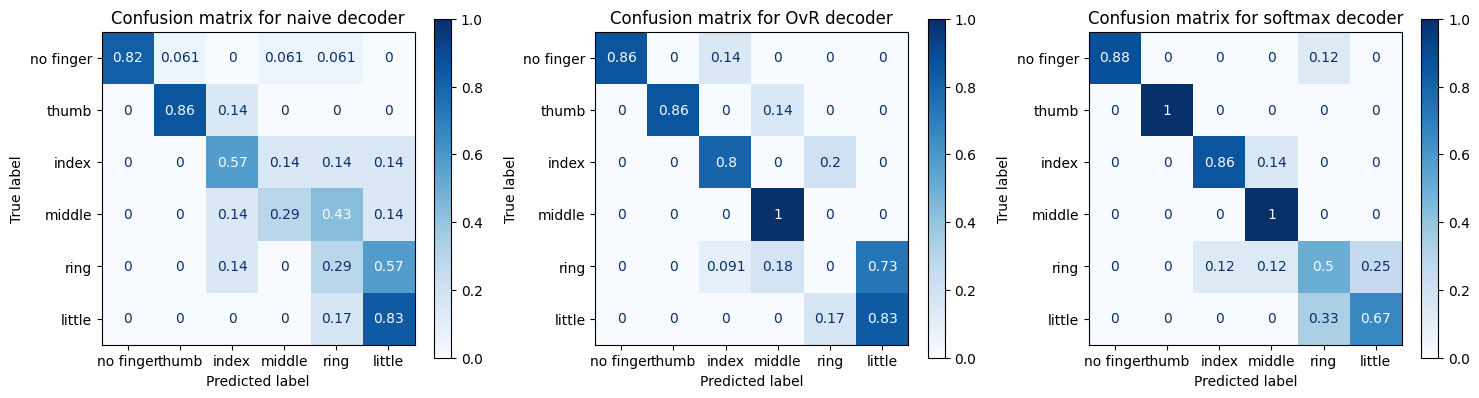

In [27]:
test_idxs = lr_sm.test_idxs

# evaluate decoder performance using confusion matrix
flex_lbls_pred_test = lr_sm.predict(flex_feats_sub[test_idxs,:])
flex_lbls_true_test = flex_lbls_sub[test_idxs]
cm_sm = confusion_matrix(flex_lbls_true_test, flex_lbls_pred_test, normalize='true')

fig, ax = plt.subplots(1,3, figsize=(15,4))
cmd = ConfusionMatrixDisplay(cm_nv, display_labels=mult_lbls)
im = cmd.plot(cmap='Blues', ax=ax[0])
im.im_.set_clim(0,1)
im.ax_.set_title('Confusion matrix for naive decoder')

cmd = ConfusionMatrixDisplay(cm_ovr, display_labels=mult_lbls)
im = cmd.plot(cmap='Blues', ax=ax[1])
im.im_.set_clim(0,1)
im.ax_.set_title('Confusion matrix for OvR decoder')

cmd = ConfusionMatrixDisplay(cm_sm, display_labels=mult_lbls)
im = cmd.plot(cmap='Blues', ax=ax[2])
im.im_.set_clim(0,1)
im.ax_.set_title('Confusion matrix for softmax decoder')

fig.tight_layout()

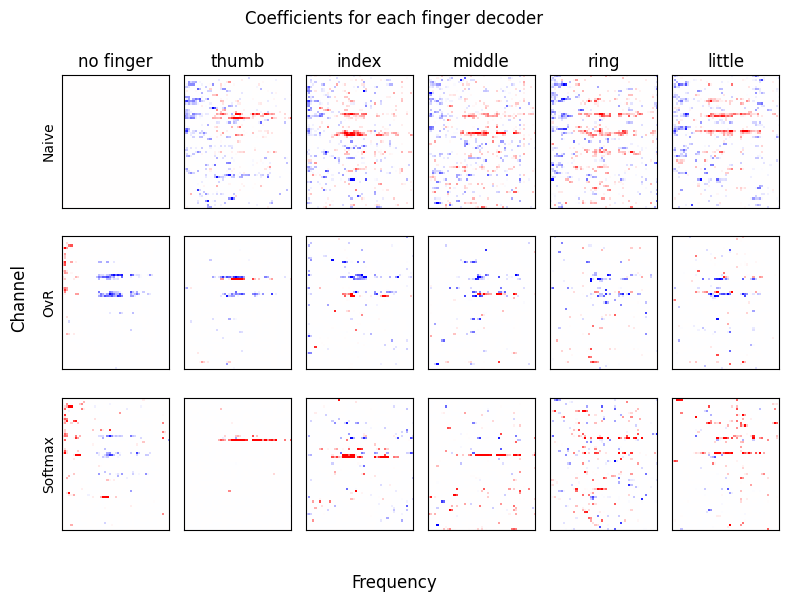

In [28]:
# Get the coefficients from each decoder
coefs_sm = np.zeros((len(mult_lbls), flex_feats_sub.shape[1]))

coefs_sm = lr_sm.get_coefs()


# plot coefficients
fig, axs = plt.subplots(3, len(mult_lbls), figsize=(8,6))
for ind, finger in enumerate(mult_lbls):
    if finger == 'no finger':
        axs[0,ind].imshow(np.zeros((63,51)), cmap='bwr', norm=plt.Normalize(-0.1,0.1), interpolation='none')
        axs[0,ind].set_title(finger)
        axs[0,ind].set_xticks([])
        axs[0,ind].set_yticks([])
    else:
        axs[0,ind].imshow(coefs_nv[ind-1,:].reshape((63,51)), cmap='bwr', norm=plt.Normalize(-0.1,0.1), interpolation='none')
        axs[0,ind].set_title(finger)
        axs[0,ind].set_xticks([])
        axs[0,ind].set_yticks([])

    
    axs[1,ind].imshow(coefs_ovr[ind,:].reshape((63,51)), cmap='bwr', norm=plt.Normalize(-0.1,0.1), interpolation='none')
    axs[1,ind].set_xticks([])
    axs[1,ind].set_yticks([])

    axs[2,ind].imshow(coefs_sm[ind,:].reshape((63,51)), cmap='bwr', norm=plt.Normalize(-0.1,0.1), interpolation='none')
    axs[2,ind].set_xticks([])
    axs[2,ind].set_yticks([])

    if ind == 0:
        axs[0,ind].set_ylabel('Naive')
        axs[1,ind].set_ylabel('OvR')
        axs[2,ind].set_ylabel('Softmax')

fig.suptitle('Coefficients for each finger decoder')
fig.supxlabel('Frequency')
fig.supylabel('Channel')
fig.tight_layout()